1. [Introduction](#Introduction)
2. [Moving MILLP500-related CSV Files to 'mill 500' Folder](#Moving-MILLP500-related-CSV-Files-to-mill-500-Folder)
3. [Visualizing Correlation Matrix](#Visualizing-Correlation-Matrix)
4. [Loading and Extracting Specific Columns from CSV Files](#Loading-and-Extracting-Specific-Columns-from-CSV-Files)
5. [Finding the Initial Time for Each CSV File](#Finding-the-Initial-Time-for-Each-CSV-File)
6. [Correcting DataFrame Columns and Filtering Data](#Correcting-DataFrame-Columns-and-Filtering-Data)
7. [Peak and Valley Detection with Data Segmentation](#Peak-and-Valley-Detection-with-Data-Segmentation)
8. [Organizing Experiment Data](#Organizing-Experiment-Data)
    - 8.1 [Signal Data Visualization with Peaks and Valleys](#Signal-Data-Visualization-with-Peaks-and-Valleys)
    - 8.2 [Shallow Feature Extraction Function](#Shallow-Feature-Extraction-Function)
    - 8.3 [Feature Extraction and Data Concatenation](#Feature-Extraction-and-Data-Concatenation)
9. [Splitting DataFrame into Parts](#Splitting-DataFrame-into-Parts)
    - 9.1 [Visualizing Signal Length Differences in a Bar Chart](#Visualizing-Signal-Length-Differences-in-a-Bar-Chart)
    - 9.2 [Defining Conditions Based on 's act/X' Sum Column for Sections [1, 2, 3, 4, 5]](#Defining-Conditions-Based-on-s-actX-Sum-Column-for-Sections-1-2-3-4-5)
10. [Data Preprocessing using Min-Max Scaling](#Data-Preprocessing-using-Min-Max-Scaling)
    - 10.1 [Autoencoder Architecture Definition](#Autoencoder-Architecture-Definition)
        - 10.1.1 [Setting Random Seed](#Setting-Random-Seed)
        - 10.1.2 [Encoder Network](#Encoder-Network)
        - 10.1.3 [Decoder Network](#Decoder-Network)
    - 10.2 [Training the Autoencoder](#Training-the-Autoencoder)
        - 10.2.1 [Importing Optimizers](#Importing-Optimizers)
        - 10.2.2 [Compiling the Autoencoder](#Compiling-the-Autoencoder)
        - 10.2.3 [Training the Autoencoder](#Training-the-Autoencoder)
    - 10.3 [Saving Model and Scaler](#Saving-Model-and-Scaler)
        - 10.3.1 [Saving the Scaler Object](#Saving-the-Scaler-Object)
        - 10.3.2 [Saving the Autoencoder Model](#Saving-the-Autoencoder-Model)
    - 10.4 [Transforming Test Data and Reconstructing using the Trained Autoencoder](#Transforming-Test-Data-and-Reconstructing-using-the-Trained-Autoencoder)
        - 10.4.1 [Transforming Test Data](#Transforming-Test-Data)
        - 10.4.2 [Obtaining Latent Space Representation](#Obtaining-Latent-Space-Representation)
        - 10.4.3 [Reconstructing Data from Latent Space](#Reconstructing-Data-from-Latent-Space)
    - 10.5 [Calculating Error Metrics and Threshold](#Calculating-Error-Metrics-and-Threshold)
        - 10.5.1 [Calculating Mean Squared Error (MSE) for Reconstructed Data](#Calculating-Mean-Squared-Error-MSE-for-Reconstructed-Data)
        - 10.5.2 [Error Percentage Calculation](#Error-Percentage-Calculation)
        - 10.5.3 [Determining Threshold](#Determining-Threshold)
        - 10.5.4 [Printing Threshold](#Printing-Threshold)
11. [Creating a Histogram of Error MSE Percentage Values](#Creating-a-Histogram-of-Error-MSE-Percentage-Values)
    - 11.1 [Sorting Error MSE Percentage Values](#Sorting-Error-MSE-Percentage-Values)
    - 11.2 [Generating the Histogram](#Generating-the-Histogram)
    - 11.3 [Adding Value Ranges and Counts to the Bars](#Adding-Value-Ranges-and-Counts-to-the-Bars)
    - 11.4 [Plot Customization](#Plot-Customization)
    - 11.5 [Displaying the Plot](#Displaying-the-Plot)
    - 11.6 [Determining Outlier Status Based on Thresholds](#Determining-Outlier-Status-Based-on-Thresholds)
        - 11.6.1 [Setting Thresholds](#Setting-Thresholds)
        - 11.6.2 [Creating a List to Store Outlier Status](#Creating-a-List-to-Store-Outlier-Status)
        - 11.6.3 [Determining Outlier Status](#Determining-Outlier-Status)
        - 


# Introduction

In this document, we'll outline the creation of a data processing pipeline designed to extract specific datasets from any folder. The pipeline will involve the extraction of particular data (such as 'mill 500' from the X axis) after unzipping the files. Subsequently, the extracted data will undergo a dedicated preprocessing phase followed by feature creation. The final objective is to train an anomaly detection model, specifically an autoencoder, tailored for our project.


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile 
import re
from scipy.stats import iqr, kurtosis, skew
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import numpy as np
from scipy.signal import find_peaks
import plotly.express as px
import warnings
import shutil
warnings.filterwarnings('ignore')


# Moving MILLP500-related CSV Files to 'mill 500' Folder

This code snippet aims to relocate CSV files associated with 'MILLP500' to a new directory named 'mill 500'.

- `mill500_folder` is created as the target directory path by joining the 'rootdir' with the 'mill 500' folder name.

- The code checks the existence of 'mill500_folder' and creates it if it doesn't exist.

- It iterates through the files in 'rootdir' and its subdirectories. For each file with an 'X.csv' extension and containing 'MILLP500', 'MillP500', or 'Mill_P500' in its name, the file path is appended to the 'MILLP500_csv' list.

- Using 'shutil.copy', the selected CSV files from 'MILLP500_csv' are copy to the 'mill500_folder'.

- Finally, a confirmation message is printed, indicating the successful relocation of the identified CSV files to the 'mill 500' folder.


In [49]:
# Specify the path to the folder containing the zip files

rootdir = r'C:\Users\sandy\Thesis\ICNAP+Predictive+Maintenance\Mill500_Measurement'
mill500_folder = os.path.join(rootdir, "mill 500")

# Create the target directory if it doesn't exist
if not os.path.exists(mill500_folder):
    os.makedirs(mill500_folder)

MILLP500_csv = []

for root, directories, files in os.walk(rootdir):
    for file_name in files:
        # Check if the file has a CSV extension
        if file_name.endswith('X.csv'):
            # Check if the file name contains MILLP500
            if ("MILLP500" in file_name) or ("MillP500" in file_name) or ("Mill_P500" in file_name):
                MILLP500_csv.append(os.path.join(root, file_name))

    # Move the selected CSV files to the target directory
for file_name in MILLP500_csv:
    shutil.copy(os.path.join(root, file_name), mill500_folder)

    # Print a confirmation message
print(f"Successfully moved {len(MILLP500_csv)} files to '{mill500_folder}' folder.")

Successfully moved 101 files to 'C:\Users\sandy\Thesis\ICNAP+Predictive+Maintenance\Mill500_Measurement\mill 500' folder.


In [68]:
df_x=pd.read_csv(MILLP500_csv[0], delimiter=';')
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130954 entries, 0 to 130953
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0         Time[us]      130954 non-null  float64
 1            PosDiff/X  130954 non-null  float64
 2              v act/X  130954 non-null  float64
 3          v (N act)/X  130954 non-null  float64
 4              s act/X  130954 non-null  float64
 5              s nom/X  130954 non-null  float64
 6              a act/X  130954 non-null  float64
 7              M ist/X  130954 non-null  float64
 8            I (nom)/X  130954 non-null  float64
 9             s diff/X  130954 non-null  float64
 10             s act/Z  130954 non-null  float64
 11                      130954 non-null  object 
dtypes: float64(11), object(1)
memory usage: 12.0+ MB


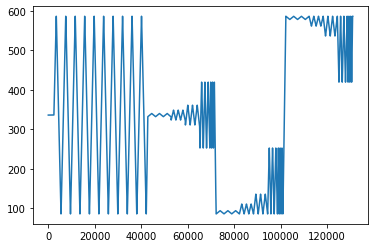

In [69]:
plt.plot(df_x.iloc[:,5:6])

# Visualizing Correlation Matrix

This code generates a heatmap to visualize the correlation matrix of the DataFrame 'df_x'.

- `plt.figure(figsize=(12, 7))` initializes a matplotlib figure object with a size of 12x7 inches.

- `sns.heatmap()` from the seaborn library is used to create a heatmap for the correlation matrix of the DataFrame 'df_x'.
  
  - `df_x.corr()` computes the correlation matrix for the DataFrame 'df_x'.
  
  - `annot=True` displays the correlation values on the heatmap.
  
  - `cmap='viridis'` sets the color map to 'viridis' for the heatmap.

- `plt.ylim(10, 0)` adjusts the limits of the y-axis to visualize the heatmap from the 10th row to the 1st row (descending order) due to the default sorting of the heatmap.

This code generates a heatmap representing the correlations between variables in the DataFrame 'df_x', aiding in identifying relationships between features.


(10.0, 0.0)

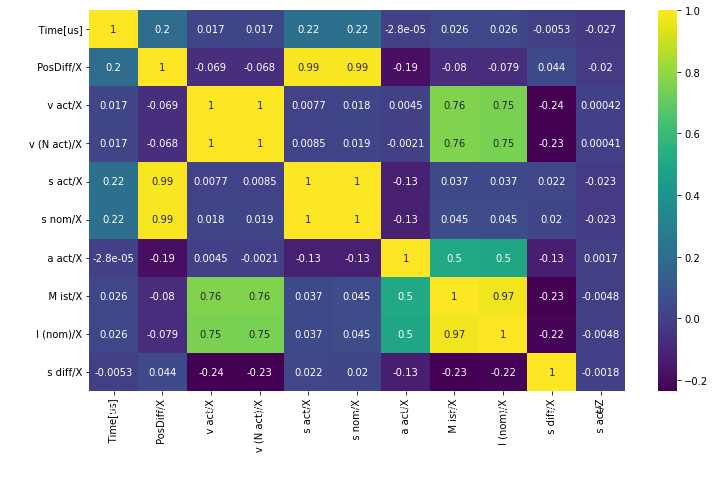

In [73]:
plt.figure(figsize=(12,7))
sns.heatmap(df_x.corr(),annot=True,cmap='viridis')
plt.ylim(10, 0)

# Loading and Extracting Specific Columns from CSV Files

The code iterates through each CSV file path in the 'MILLP500_csv' list, reads the data, and extracts specific columns based on the provided 'column_indices'.

- `column_indices = [0, 1, 2, 4, 6, 8, 9]` defines the indices of the columns to be extracted from the CSV files.

- `selected_df = []` initializes an empty list to store the extracted dataframes.

- A loop iterates through each 'csv_file_path' in 'MILLP500_csv':

  - `pd.read_csv(csv_file_path, usecols=column_indices, delimiter=';')` reads the CSV file specified by 'csv_file_path' and selects columns specified in 'column_indices'. The 'delimiter=';'` argument indicates that the delimiter used in the CSV file is a semicolon.

  - The extracted data is stored in a dataframe, and each resulting dataframe is appended to the 'selected_df' list.

This code reads multiple CSV files from the 'MILLP500_csv' list, extracts specific columns based on 'column_indices', and stores the resulting dataframes in the 'selected_df' list.


In [71]:
column_indices = [0, 1, 2, 4, 6, 8, 9]

selected_df = []

for csv_file_path in MILLP500_csv: 
    data = pd.read_csv(csv_file_path, usecols=column_indices, delimiter=';')
    selected_df.append(data)

In [82]:
selected_df[0].head()

,Time[us],PosDiff/X,v act/X,s act/X,a act/X,I (nom)/X,s diff/X
0,-392859000.0,0.008145,0.292969,336.000007,0.002170,-0.231397,-0.000007
1,-392856000.0,0.008128,-0.195312,335.999997,-0.002713,-0.208008,0.000003
2,-392853000.0,0.008158,0.585938,336.000026,0.004340,-0.326493,-0.000026
3,-392850000.0,0.008145,-0.390625,336.000007,-0.005425,-0.312831,-0.000007
4,-392847000.0,0.008170,0.488281,336.000031,0.004883,-0.136800,-0.000031


# Finding the Initial Time for Each CSV File

The code snippet determines the initial time for each CSV file in the 'selected_df' list.

- `selected_time = []` initializes an empty list to store the initial time values.

- A loop iterates through each dataframe in the 'selected_df' list using the index 'i':

  - `selected_df[i].iloc[:,0][1]` extracts the second value (index 1) from the first column (index 0) of each dataframe 'selected_df[i]'. This value is assumed to represent time data.

  - The extracted time value is appended to the 'selected_time' list.

- `initial_time = max(selected_time)` calculates the maximum value (latest initial time) among the collected time values in the 'selected_time' list.

- `print(f"The initial file for every CSV file is: {initial_time}")` displays the maximum initial time value found among all the CSV files.

This code snippet extracts time data from each CSV file's first column and identifies the latest initial time among these values, providing insight into the starting time for each dataset.


In [77]:
selected_time=[]
for i in range(len(selected_df)):
     selected_time.append(selected_df[i].iloc[:,0][1])
            
initial_time= max (selected_time)
print(f"The initial file for every CSV file is :{initial_time}")

The initial file for every CSV file is :-392856000.0


# Correcting DataFrame Columns and Filtering Data

The code snippet aims to correct the column names of DataFrames in the 'selected_df' list and filter data based on a specific time threshold.

- `expected_columns` is a list containing the corrected column names: 'Time[us]', 'PosDiff/X', 'v act/X', 's act/X', 'a act/X', 'I (nom)/X', and 's diff/X'.

- `corrected_dfs = []` initializes an empty list to store corrected DataFrames.

- The code loops through each DataFrame 'df' in the 'selected_df' list:

  - `for col in df.columns:` iterates through each column name in the DataFrame columns.

  - `df.columns = expected_columns` replaces the existing column names in 'df' with the predefined 'expected_columns' list.

  - `df = df[df['Time[us]'] >= initial_time].reset_index(drop=True)` filters the rows in 'df' where the 'Time[us]' column values are greater than or equal to the 'initial_time' threshold. The filtered DataFrame is reset with a new index.

  - The resulting filtered and corrected DataFrame 'df' is appended to the 'corrected_dfs' list.

This code snippet corrects the column names of each DataFrame in the 'selected_df' list to match the expected columns and filters the data based on a specified initial time threshold.


In [84]:
expected_columns = ['Time[us]','PosDiff/X', 'v act/X', 's act/X','a act/X', 'I (nom)/X', 's diff/X']

corrected_dfs = []

for df in selected_df:
    for col in df.columns:
        df.columns = expected_columns
    
    #df.iloc[:,3] = df.iloc[:,3]
    df = df[df['Time[us]'] >= initial_time].reset_index(drop=True)
    corrected_dfs.append(df)

# Peak and Valley Detection with Data Segmentation
............................................................................................................................................................................................................


In this code snippet, we perform several data processing steps, including peak and valley detection, segmentation, and creating segmented dataframes. Here's a breakdown of the key operations:

1. **Peak Detection**: We use the `find_peaks` function to detect peaks in the third column of the `df_corr` DataFrame and store the indices of the detected peaks in the `peaks` variable.

2. **Valley Detection**: Similarly, we detect valleys by negating the signal data and storing the indices in the `valleys` variable.

3. **Filtering Peaks and Valleys**: We calculate the length of peaks and valleys that meet specific criteria based on data range and values.

4. **Warm-up Length**: We compute the `warm_len` as the sum of valid peaks and valleys lengths.

5. **Data Segmentation Parameters**: We determine the `start_point`, `end_point`, and `step_size` to define segments for further data processing.

6. **Segmented Data Preparation**: We create a list named `exp_corr` and populate it with segmented dataframes from the original `df_corr` based on the defined segments. The dataframes are indexed and stored in the list, and the segmentation is based on both valleys and peaks depending on the iteration.

This code is essential for segmenting the data into smaller chunks, which can be further analyzed or processed independently. It makes use of peak and valley detection to define these segments and collect the data within them.


In [88]:
signal_data= corrected_dfs
peaks_idx= []
valleys_idx= []
req_segment_idx=[] 
experiments = []

for i in range(len(signal_data)):
    peaks, _ = find_peaks(signal_data[i].iloc[:,3])
    peaks_idx.append(peaks)
    valleys, _ = find_peaks(-signal_data[i].iloc[:,3])  # Find valleys by negating the signal data
    valleys_idx.append(valleys)
    
    a= len(signal_data[i].iloc[:,3][valleys][(signal_data[i].iloc[:,3][valleys] > 50) & (signal_data[i].iloc[:,3][valleys] < 600) & (signal_data[i].iloc[:,3][valleys].index<20000)].index)
    b= len(signal_data[i].iloc[:,3][peaks][(signal_data[i].iloc[:,3][peaks] > 500) & (signal_data[i].iloc[:,3][peaks] < 600) & (signal_data[i].iloc[:,3][peaks].index>20000) & (signal_data[i].iloc[:,3][peaks].index<80000)].index) 

    warm_len= a + b

    start_point = warm_len
    end_point = peaks.shape[0]

    # Calculate the step size based on the number of steps (3 in this case)
    step_size = 3
    # Create the array with multiples of 3 till 15 times
    req_segment= np.arange(warm_len, end_point,step_size)
    req_segment_idx.append(req_segment)
   

    exp = []
      
    for j in range(0,5):
        exp.append(pd.DataFrame(signal_data[i][valleys[req_segment[j]]: valleys[req_segment[j+1]]]).reset_index(drop= True))
    for j in range(5,10):
        exp.append(pd.DataFrame(signal_data[i][valleys[req_segment[j]]: valleys[req_segment[j+1]]]).reset_index(drop=True))
    for j  in range(10,15):
        exp.append(pd.DataFrame(signal_data[i][peaks[req_segment[j]]: peaks[req_segment[j+1]]]).reset_index(drop=True))
    experiments.append(exp)

# Organizing Experiment Data

The code snippet organizes experiment data into separate lists based on different filtering conditions for further analysis.

- Several lists such as `exp1_1`, `exp1_2`, ..., `exp3_5` are created to store filtered experiment data.
  
- For each list, the code iterates through the experiment data stored in the 'experiments' list:

    - Conditions are applied to filter the experiment data based on specific column values using `iloc`.
    
    - Filtered data is appended to the respective lists based on the conditions.

- Finally, three groups of lists (`exp_1`, `exp_2`, `exp_3`) are created to categorize the filtered data into different experiments.
  
    - `exp_1` contains lists `exp1_1` to `exp1_5`.
    
    - `exp_2` contains lists `exp2_1` to `exp2_5`.
    
    - `exp_3` contains lists `exp3_1` to `exp3_5`.

This code segment categorizes the experiment data into distinct lists based on various filtering conditions, organizing it for further analysis or processing.


In [90]:
exp1_1 =[]
for i in range(len(signal_data)):
    exp1_1.append(experiments[i][0][experiments[i][0].iloc[:,3]> 332].reset_index(drop= True))

exp1_2= []
for i in range(len(signal_data)):
    exp1_2.append(experiments[i][1][experiments[i][1].iloc[:,3]>323])

exp1_3= []
for i in range(len(signal_data)):
    exp1_3.append(experiments[i][2][experiments[i][2].iloc[:,3]>310])

exp1_4=[]
for i in range(len(signal_data)):
    exp1_4.append(experiments[i][3])

exp1_5=[]
for i in range(len(signal_data)):
    exp1_5.append(experiments[i][4][experiments[i][4].iloc[:,3]>250])

exp2_1=[]
for i in range(len(signal_data)):
    exp2_1.append(experiments[i][5])
    
exp2_2=[]
for i in range(len(signal_data)):
    exp2_2.append(experiments[i][6])

exp2_3=[]
for i in range(len(signal_data)):
    exp2_3.append(experiments[i][7])

exp2_4=[]
for i in range(len(signal_data)):
    exp2_4.append(experiments[i][8])

exp2_5=[]
for i in range(len(signal_data)):
    exp2_5.append(experiments[i][9])
    
    
exp3_1=[]
for i in range(len(signal_data)):
    exp3_1.append(experiments[i][10])

exp3_2=[]
for i in range(len(signal_data)):
    exp3_2.append(experiments[i][11])
    
exp3_3=[]
for i in range(len(signal_data)):
    exp3_3.append(experiments[i][12])

exp3_4=[]
for i in range(len(signal_data)):
    exp3_4.append(experiments[i][13])

exp3_5=[]
for i in range(len(signal_data)):
    exp3_5.append(experiments[i][14])


exp_1 = [exp1_1, exp1_2, exp1_3, exp1_4, exp1_5] 
exp_2 = [exp2_1, exp2_2, exp2_3, exp2_4, exp2_5] 
exp_3 = [exp3_1, exp3_2, exp3_3, exp3_4, exp3_5]

## Signal Data Visualization with Peaks and Valleys

............................................................................................................................................................................................................


In this code snippet, we visualize the signal data with lines separating segments, and we highlight peaks (in red) and valleys (in blue). The code performs the following tasks:

1. **Figure Creation**: We create a figure with a size of 20x10 to prepare for plotting the signal data.

2. **Plotting the Original Signal**: We plot the original signal data, which is stored in the DataFrame `signal_data` and is taken from the third column. The `label` parameter specifies the legend label for this line.

3. **Plotting Peaks and Valleys**: Peaks are marked in red ('r.') and valleys in blue ('b.'). We use the `peaks` and `valleys` indices calculated earlier to identify these points in the signal.

4. **Legend and Labels**: We add a legend to the plot to distinguish the original signal from the peaks and valleys. We also provide labels for the x-axis and y-axis and set the plot title.

5. **Grid Lines**: Grid lines are added to the plot to aid in visual reference.

6. **Display Plot**: Finally, we use `plt.show()` to display the plot.

This code snippet allows you to visualize the signal data, identify peaks and valleys, and clearly see the segments in the data, helping you better understand the behavior of the signal.


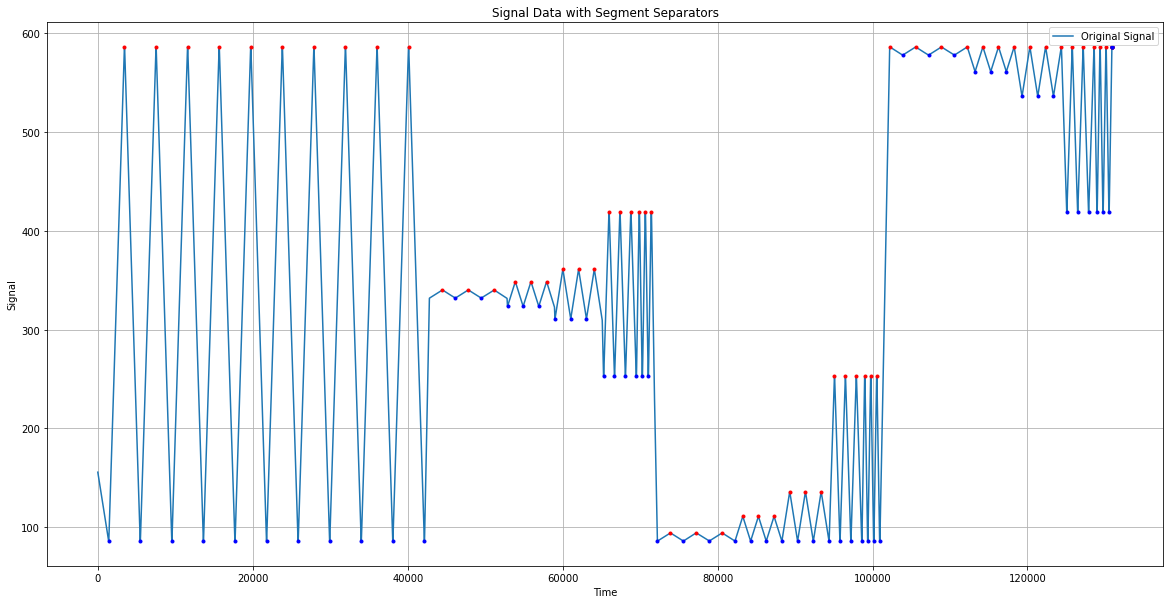

In [91]:
# Plot the signal data with lines separating the segments
a = 41  
plt.figure(figsize=(20, 10))
plt.plot(signal_data[a].iloc[:,3], label='Original Signal')

# Plot peaks (red) and valleys (blue)
plt.plot(signal_data[a].iloc[:,3].index[peaks_idx[a]],signal_data[a].iloc[:,3][peaks_idx[a]], 'r.')
plt.plot(signal_data[a].iloc[:,3].index[valleys_idx[a]],signal_data[a].iloc[:,3][valleys_idx[a]], 'b.')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Signal Da +69-*ta with Segment Separators')
plt.grid(True)
plt.show()

## Shallow Feature Extraction Function

............................................................................................................................................................................................................

This Python function, named `fun_shallow_feature`, is designed for extracting a set of basic statistical features from a given input signal `x`. These features provide insights into the characteristics of the signal. Here's an explanation of the features and their calculations within the function:

- **Interquartile Range (iqr_val)**: It is computed as the difference between the third quartile (75th percentile) and the first quartile (25th percentile) of the input signal.

- **Kurtosis (kurt)**: Kurtosis measures the "tailedness" of the signal's probability distribution. It quantifies how much the data deviates from a normal distribution. A high kurtosis value indicates heavy tails.

- **Skewness (skewness)**: Skewness measures the asymmetry of the signal's distribution. Positive skewness indicates a long tail on the right, while negative skewness indicates a long tail on the left.

- **Root Mean Square (rms)**: RMS is a measure of the signal's energy. It is computed as the square root of the mean of the squared values of the signal.

- **Variance (variance)**: Variance measures the spread or dispersion of the signal. It is the average of the squared differences from the Mean.

- **Mean (mean_val)**: This is the arithmetic average of the input signal.

- **Maximum (max_val)**: It represents the highest value in the signal.

- **Minimum (min_val)**: It represents the lowest value in the signal.

- **Standard Deviation (std_dev)**: Standard deviation quantifies the amount of variation or dispersion in the signal.

- **Median (median_val)**: The median is the middle value of the signal when it is sorted. It is less sensitive to outliers than the mean.

- **Sum (summ)**: The sum of all values in the signal, scaled by a factor of 10,000.

The function returns a list of these computed features. In case of missing or non-numeric values in the input signal, the function replaces them with zeros using `np.nan_to_num`.

This function is useful for quickly obtaining fundamental statistics that can help characterize a given signal.


In [92]:
def fun_shallow_feature(x):
    # Raw signal features
    iqr_val = iqr(x)  # Interquartile Range
    kurt = kurtosis(x)  # Kurtosis
    skewness = skew(x)  # Skewness
    rms = sqrt(np.mean(np.square(x)))  # Root Mean Square
    variance = np.var(x)  # Variance
    mean_val = np.mean(x)  # Mean
    max_val = np.max(x)  # Maximum
    min_val = np.min(x)  # Minimum
    std_dev = np.std(x)  # Standard Deviation
    median_val = np.median(x)# Median
    summ= sum(x)/(10e+3)

    features = [iqr_val, kurt, skewness, rms, variance, mean_val, max_val, min_val, std_dev, median_val, summ]
    features = np.nan_to_num(features, nan=0, posinf=0, neginf=0)
    
    return features 

## Feature Extraction and Data Concatenation

............................................................................................................................................................................................................

In this code snippet, we perform feature extraction and data concatenation to create a final DataFrame. The code is organized into nested loops for this purpose. Here's a breakdown of the key operations:

1. **Nested Loop Structure**: The code contains three nested loops, with each loop serving a specific purpose:
   - The outermost loop (`l`) iterates over three different experiments or data sets.
   - The middle loop (`i`) iterates over five different segments within each experiment.
   - The innermost loop (`j`) iterates just once (value 0) to handle each segment.

2. **Feature Extraction**: For each combination of `(l, i, j)`, a set of shallow features is extracted from the respective segment within the experiment. The `fun_shallow_feature` function is applied to each of the six columns (`k`) in the segment to obtain 66 features.

3. **Data Organization**: The extracted features are organized into a single list named `fea_i_single`. This list contains the features for a specific `(l, i, j)` combination.

4. **Data Concatenation**: The `fea_i_single` lists are concatenated along the rows to form the `df_final_exp` DataFrame, which contains the feature vectors for all combinations of `(l, i, j)`.

5. **Column Prefix Addition**: The columns of the `df_final_exp` DataFrame are given prefixes ('c') for clarity and to distinguish them from the original data columns.

The result is a final DataFrame, `df_final_exp`, that contains the extracted features for various segments within three different experiments. These features can be used for further analysis or modeling.


In [104]:
fea_i = []
exp_type = exp_1 ### here only section 1-5 are choosen. exp_2 and exp_3 contains from 6-15 respectivily.

df_final_exp = pd.DataFrame()
for i in range(len(exp_type)):
    for j in range(len(signal_data)):
        fea_i_single = []
        for k in range(6):
            fea_i_single.append(fun_shallow_feature(exp_type[i][j].iloc[:, k+1]))
        
        fea_i.append(pd.DataFrame(np.array(fea_i_single).reshape(1,66)))

df_final_exp = pd.concat(fea_i, axis=0, ignore_index=True)
df_final_exp = df_final_exp.add_prefix('c')


In [105]:
df_final_exp.iloc[0:101,:].head() ### section 1.1

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c56,c57,c58,c59,c60,c61,c62,c63,c64,c65
0,0.002949,-1.942770,0.032434,0.008269,2.204873e-06,0.008135,0.010212,0.006215,0.001485,0.007618,...,51.660674,3.250248,0.000051,2.608427e-09,-5.276427e-07,0.000850,-0.000391,0.000051,0.0,-5.170898e-07
1,0.001918,-1.921917,0.004809,0.002941,9.348848e-07,0.002777,0.004080,0.001423,0.000967,0.002445,...,37.855555,-0.669267,0.000041,1.703618e-09,-8.484762e-08,0.000547,-0.000693,0.000041,0.0,-8.642578e-08
2,0.003231,-1.879938,0.020965,0.005937,2.624631e-06,0.005712,0.007876,0.003616,0.001620,0.005447,...,226.413358,-10.374703,0.000048,2.260793e-09,-1.916432e-06,0.000405,-0.001187,0.000048,0.0,-1.876953e-06
3,0.001833,-1.941448,-0.010703,0.002411,8.333076e-07,0.002231,0.003373,0.001063,0.000913,0.002385,...,112.429259,-3.456552,0.000036,1.296579e-09,-4.832988e-08,0.000488,-0.000859,0.000036,0.0,-4.736328e-08
4,0.001909,-1.964762,0.003469,0.006835,9.204378e-07,0.006768,0.007968,0.005467,0.000959,0.006723,...,28.269642,-1.373212,0.000047,2.243033e-09,-1.534598e-07,0.000415,-0.000767,0.000047,0.0,-1.503906e-07


# Splitting DataFrame into Parts

This code snippet divides the DataFrame `df_final_exp` into five equal parts ('Part_1' to 'Part_5') based on the column 'c32'.

- The DataFrame is divided into five equal sections using integer-based indexing.
  
- Each part is extracted using the 'iloc' method, segmenting the data based on its size divided into five parts.
  
- A new DataFrame `sum_df` is created, aggregating these parts into respective columns ('Part_1' to 'Part_5').

- Each column in the new DataFrame represents one of the five parts obtained from the original DataFrame.

This code efficiently splits the DataFrame into five equal parts, organizing them into columns in a new DataFrame for further analysis or visualization.


In [106]:

df= df_final_exp
part_size = len(df) // 5
part1 = df['c32'].iloc[0:part_size].values
part2 = df['c32'].iloc[part_size:2*part_size].values
part3 = df['c32'].iloc[2*part_size:3*part_size].values
part4 = df['c32'].iloc[3*part_size:4*part_size].values
part5 = df['c32'].iloc[4*part_size:].values

sum_df = pd.DataFrame({
    'Part_1': part1,  ##section 1.1
    'Part_2': part2,   ##section 1.2
    'Part_3': part3,   ##section 1.3
    'Part_4': part4,   ##section 1.4
    'Part_5': part5  ##section 1.5
})
sum_df

,Part_1,Part_2,Part_3,Part_4,Part_5
0,329.361660,203.572495,204.772416,141.923896,77.556462
1,342.334498,211.467971,212.635070,147.064810,80.004761
2,329.160063,203.470973,204.639136,141.828703,77.547226
3,329.361660,203.572500,204.772428,141.923896,77.556493
4,329.361661,203.604818,204.741360,141.923896,77.556578
...,...,...,...,...,...
96,328.084515,202.799964,204.000077,141.420297,98.508668
97,329.361660,203.167802,204.168911,140.684653,97.127373
98,264.822541,188.325466,170.057726,127.580131,65.545171
99,329.160060,203.001618,204.066604,140.614639,97.102309


## Visualizing Signal Length Differences in a Bar Chart

This code generates a bar chart to display differences in signal length across a dataset. The chart showcases the variation in the length of signals from the 'exp_1' dataset.

- The code initializes empty lists 'sum_val' and 'temp' to store the cumulative length of signals and iterate through the dataset respectively.

- Using a for loop, the code calculates the cumulative length of signals for each element in the 'exp_1' dataset, considering the fourth column ('iloc[:,3]') as the length indicator.

- The cumulative lengths (divided by 10,000 for scaling purposes) are stored in 'sum_val' while 'temp' keeps track of the iterations.

- Finally, a bar chart is created using Matplotlib's 'plt.bar()' function. It represents the differences in signal length across the dataset, with the x-axis depicting individual data elements and the height of the bars indicating the scaled cumulative signal lengths.

This visualization provides an overview of how the lengths of signals vary across the dataset, aiding in understanding the distribution of signal lengths within the 'exp_1' dataset.


<BarContainer object of 101 artists>

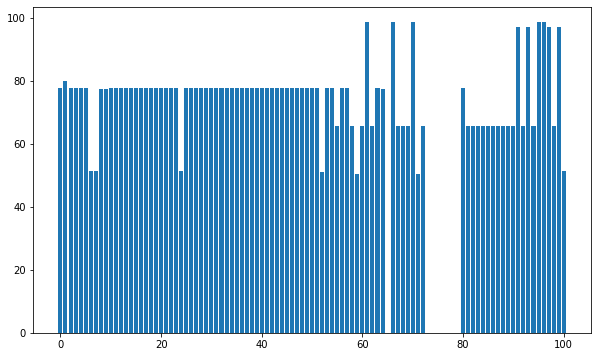

In [121]:
## bar showing thedifference in length of a signal
sum_val=[]
temp=[]
exp_type= exp_1
plt.figure(figsize=(10,6))
for i in range(len(exp1_1)):
        temp.append(i)
        sum_val.append(sum(exp_type[4][i].iloc[:,3])/10000) #### choosing section 1.X
        
plt.bar(height=sum_val, x= np.arange(0,len(temp)))

## Defining Conditions Based on 's act/X' Sum Column for Sections [1, 2, 3, 4, 5]

This code defines five distinct conditions ('condition_1' through 'condition_5') based on the cumulative sum of the 's act/X' column ('c32') within specific index ranges.

- 'condition_1': Represents a condition where the 's act/X' sum falls between 325 and 332 within the index range 0 to 101.
- 'condition_2': Represents a condition where the 's act/X' sum falls between 200 and 205 within the index range 102 to 202.
- 'condition_3': Represents a condition where the 's act/X' sum falls between 202 and 206 within the index range 203 to 303.
- 'condition_4': Represents a condition where the 's act/X' sum falls between 139 and 143 within the index range 304 to 404.
- 'condition_5': Represents a condition where the 's act/X' sum falls between 75 and 80 within the index range 405 to 505.

These conditions define specific criteria based on the cumulative sums of the 's act/X' column within different index ranges. They are established for further data analysis, allowing segmentation of data based on predefined conditions for each section [1, 2, 3, 4, 5].


In [122]:
#### selecting the condition according to the sum column of sact/x for section [1,2,3,4,5]

condition_1= (df_final_exp['c32']>=325) & (df_final_exp['c32']<=332) & (0 <= df_final_exp.index) & (df_final_exp.index <= 101)
condition_2= (df_final_exp['c32']>=200) & (df_final_exp['c32']<=205) & (102 <= df_final_exp.index) & (df_final_exp.index <= 202)
condition_3= (df_final_exp['c32']>=202) & (df_final_exp['c32']<=206) & (203 <= df_final_exp.index) & (df_final_exp.index <= 303)
condition_4= (df_final_exp['c32']>=139) & (df_final_exp['c32']<=143) & (304 <= df_final_exp.index) & (df_final_exp.index <= 404)
condition_5= (df_final_exp['c32']>=75) & (df_final_exp['c32']<=80) & (405 <= df_final_exp.index) & (df_final_exp.index <= 505) 

# Data Preprocessing using Min-Max Scaling

The code snippet demonstrates the process of preparing data for a machine learning model, particularly an autoencoder, by performing data preprocessing steps using Min-Max Scaling.

- `X_train`: The variable 'X_train' is assigned the data subset based on 'condition_1' from the 'df_final_exp1' dataset. 'condition_1' represents a specific subset of data based on defined conditions for the 's act/X' column ('c32').

- `MinMaxScaler()`: A 'MinMaxScaler' object is initialized to scale the data within a specific range (default range is [0, 1]).

- `scaler.fit(X_train)`: The scaler is fitted on the 'X_train' data. This step computes the minimum and maximum values of the features to be used for later scaling.

- `X_train = scaler.transform(X_train.values)`: Finally, the 'X_train' data is transformed using the previously fitted scaler. This transformation scales the features in the 'X_train' dataset based on the minimum and maximum values computed during the fitting step.

This process ensures that the data is scaled within a predefined range, which is a crucial step in preparing the data for training machine learning models, especially neural networks like autoencoders.


In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

X_train = df_final_exp[condition_1]
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train= scaler.transform(X_train.values)

In [130]:
print (X_train.shape)

(64, 66)


## Autoencoder Architecture Definition

The code snippet showcases the definition of an autoencoder neural network architecture using TensorFlow's Keras API.

### Setting Random Seed
- `tf.compat.v1.random.set_random_seed(123)`: This line sets the random seed to ensure reproducibility of results in TensorFlow. Setting the random seed helps in obtaining consistent and repeatable results when training neural networks.

### Encoder Network
- The 'encoder' is defined as a Sequential model:
    - The first layer comprises a Dense (fully connected) layer with 32 units and ReLU activation function. It takes an input shape of [66], indicating 66 features/columns.
    - The subsequent layer consists of 16 units with ReLU activation, taking an input shape of [32].
    - The third layer further reduces the dimensionality to 8 units with ReLU activation and input shape [16].

### Decoder Network
- The 'decoder' is another Sequential model:
    - It starts with a Dense layer having 16 units and ReLU activation, expecting an input shape of [8].
    - The subsequent layer consists of 32 units with ReLU activation and an input shape of [16].
    - The final layer reconstructs the output with 66 units using a Sigmoid activation function, expecting an input shape of [32].

This architecture represents an autoencoder network with an encoder part that compresses the input data into a lower-dimensional representation and a decoder part that aims to reconstruct the original input from the compressed representation.


In [132]:
tf.compat.v1.random.set_random_seed(123)

encoder = Sequential()
encoder.add(Dense(units =32,activation='relu',input_shape=[66]))
encoder.add(Dense(units =16,activation='relu',input_shape=[32]))
encoder.add(Dense(units =8,activation='relu',input_shape=[16]))

decoder = Sequential()
decoder.add(Dense(units=16,activation='relu',input_shape=[8]))
decoder.add(Dense(units=32,activation='relu',input_shape=[16]))
decoder.add(Dense(units=66,activation='sigmoid',input_shape=[32]))

## Training the Autoencoder

The code snippet demonstrates the training phase of the previously defined autoencoder neural network using TensorFlow's Keras API.

### Importing Optimizers
- `from tensorflow.keras.optimizers import Adam, RMSprop`: This line imports the Adam and RMSprop optimizers from TensorFlow. These optimizers are used to adjust the neural network's weights during training to minimize the defined loss function.

### Compiling the Autoencoder
- `autoencoder = Sequential([encoder, decoder])`: This creates an autoencoder model by stacking the previously defined 'encoder' and 'decoder' models into a single sequential model.
- `autoencoder.compile(loss="mse" ,optimizer='adam')`: Compiles the autoencoder model. It configures the model for training using the Mean Squared Error (MSE) loss function and the Adam optimizer.

### Training the Autoencoder
- `autoencoder.fit(X_train, X_train, epochs=200, verbose=0)`: Initiates the training process for the autoencoder. It trains the model using the input data 'X_train' as both input and target (reconstruction target). The 'epochs' parameter specifies the number of iterations over the entire dataset during training. Here, 200 epochs are set for training without displaying verbose output during training (verbose=0).

The model is trained to minimize the reconstruction error between the input and output (reconstructed) data using the MSE loss function, optimizing the weights using the Adam optimizer over 200 training epochs.


In [134]:
from tensorflow.keras.optimizers import Adam, RMSprop
autoencoder = Sequential([encoder,decoder])
autoencoder.compile(loss="mse" ,optimizer='adam')

autoencoder.fit(X_train,X_train,epochs=200,verbose=0)

## Saving Model and Scaler

The provided code snippet demonstrates the process of saving the trained autoencoder model and the scaler object using the `joblib` library in Python.

### Saving the Scaler Object
- `joblib.dump(scaler, 'ICNAP+Predictive+Maintenance/Saved_weights/scaler_1.1')`: This line saves the scaler object used for data normalization during training. The `joblib.dump()` function from the `joblib` library is used to save the scaler object as a file named 'scaler_1.1' in the specified directory 'ICNAP+Predictive+Maintenance/Saved_weights'.

### Saving the Autoencoder Model
- `autoencoder.save('ICNAP+Predictive+Maintenance/Saved_weights/my_model_exp_1.1')`: This line saves the trained autoencoder model. The `save()` method provided by TensorFlow's Keras API saves the entire model architecture, including the model configuration, architecture, and trained weights. The model is saved with the name 'my_model_exp_1.1' in the specified directory 'ICNAP+Predictive+Maintenance/Saved_weights'.


In [136]:
import joblib
joblib.dump(scaler, 'ICNAP+Predictive+Maintenance/Saved_weights/scaler_1.1')
autoencoder.save('ICNAP+Predictive+Maintenance/Saved_weights/my_model_exp_1.1')

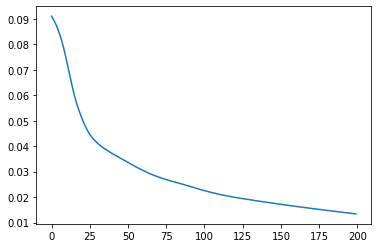

In [137]:
losses = pd.DataFrame(autoencoder.history.history)
plt.plot(losses)

## Transforming Test Data and Reconstructing using the Trained Autoencoder

The code snippet performs transformations on the test data and reconstructs it using the trained autoencoder model.

### Transforming Test Data
- `X_test = scaler.transform(df_final_exp.iloc[0:101,].values)`: This line scales the test data using the previously fitted `scaler` object. It selects the first 101 rows from the DataFrame `df_final_exp`, transforms the data using the scaler, and stores it in `X_test`.

### Obtaining Latent Space Representation
- `latent_space = encoder.predict(X_test)`: This code segment passes the scaled test data `X_test` through the encoder part of the trained autoencoder model (`encoder`) to obtain the latent space representation. It generates the encoded/latent representations of the test data.

### Reconstructing Data from Latent Space
- `reconstructed_data = decoder.predict(latent_space)`: Here, the code utilizes the decoder part of the trained autoencoder model (`decoder`) to reconstruct the data from the obtained latent space representations (`latent_space`). It reconstructs the test data back to its original space using the decoder.


In [144]:
X_test = scaler.transform(df_final_exp.iloc[0:101,].values)

latent_space = encoder.predict(X_test)

reconstructed_data= decoder.predict(latent_space)

## Calculating Error Metrics and Threshold

### Calculating Mean Squared Error (MSE) for Reconstructed Data
- `Error = df_final_exp.iloc[0:101,]`: Selects the first 101 rows of the `df_final_exp` DataFrame for error computation.
- `mse = np.mean((X_test - reconstructed_data) ** 2, axis=1)`: Computes the mean squared error (MSE) between the scaled test data (`X_test`) and the reconstructed data (`reconstructed_data`).
- `max_error = mse.max()`: Determines the maximum error value among the MSE values obtained.

### Error Percentage Calculation
- `Error['Error_Mse'] = mse`: Creates a new column named `Error_Mse` in the `Error` DataFrame to store the calculated MSE values.
- `mse_percentage = Error.Error_Mse.apply(lambda x: (x/max_error)*100)`: Calculates the error percentage by scaling the MSE values with respect to the maximum error value. It computes the error percentage for each MSE value.
- `Error['Error_percentage'] = mse_percentage`: Creates a new column `Error_percentage` in the `Error` DataFrame to store the computed error percentages.

### Determining Threshold
- `threshold = Error.loc[Error['Error_percentage'] > 95, 'Error_Mse'].min()`: Attempts to set a threshold based on the minimum MSE among the rows where the `Error_percentage` is greater than 95%. However, it calculates the `threshold` based on the MSE values, not on the error percentage as intended.

### Printing Threshold
- `print(threshold)`: Prints the computed threshold value.


In [256]:
Error= df_final_exp.iloc[0:101,]
mse = np.mean((X_test - reconstructed_data) ** 2, axis=1)
max_error= mse.max()
Error['Error_Mse'] = mse

mse_percentage = Error.Error_Mse.apply(lambda x: (x/max_error)*100)
Error['Error_percentage']= mse_percentage

# Creating a Histogram of Error MSE Percentage Values

## Sorting Error MSE Percentage Values
- `error_mse = pd.Series(mse_percentage).sort_values(ascending=True)`: Converts `mse_percentage` into a Pandas Series and sorts it in ascending order.

## Generating the Histogram
- `plt.figure(figsize=(10, 6))`: Sets the figure size to 10x6 for the plot.
- `hist, bins, _ = plt.hist(error_mse, bins=20, edgecolor='black')`: Creates a histogram of the sorted MSE percentage values (`error_mse`) with 20 specified bins. The histogram is plotted, and bin edges are highlighted with black edges.

## Adding Value Ranges and Counts to the Bars
- `for i in range(len(bins) - 1):`: Loops through each bin.
    - `bin_start = bins[i]`: Captures the start value of the bin.
    - `bin_end = bins[i+1]`: Captures the end value of the bin.
    - `bin_text = f'({bin_start:.2f}, {bin_end:.2f})'`: Formats the text for the bin edge values.
    - `plt.text(bin_start, hist[i] + 0.1, bin_text, ha='right', fontsize=10)`: Places text annotations on the right side of each bar representing the range of values within each bin.
    - `plt.text(bins[i] + (bins[i+1] - bins[i]) / 2, hist[i] + 0.1, f'{int(hist[i])}', ha='center', fontsize=12)`: Adds text annotations above the bars representing the count of MSE percentage values within each bin. The annotations are centered above the bars.

## Plot Customization
- `plt.xlabel('Error MSE')`: Sets the label for the x-axis.
- `plt.ylabel('Frequency')`: Sets the label for the y-axis.
- `plt.title('Histogram of Error MSE')`: Sets the title for the plot.

## Displaying the Plot
- `plt.show()`: Displays the plot with the histogram and annotations.


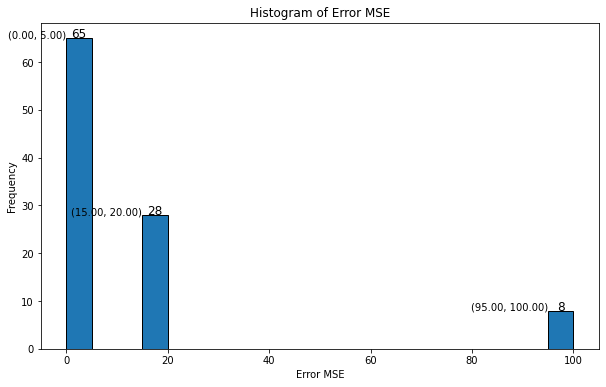

In [257]:
error_mse = pd.Series(mse_percentage).sort_values(ascending=True)

# Create a larger figure for the plot
plt.figure(figsize=(10, 6))

# Create a histogram
hist, bins, _ = plt.hist(error_mse, bins=20, edgecolor='black')

# Add value counts on top of the bars with increased font size
for i in range(len(bins) - 1):
    bin_start = bins[i]
    bin_end = bins[i+1]
    if hist[i] > 0 :
        bin_text = f'({bin_start:.2f}, {bin_end:.2f})'  # Format the text for the bin edge values
        plt.text(bin_start, hist[i] + 0.1, bin_text, ha='right', fontsize=10)  # Adjust position for bin edge text
        plt.text(bins[i] + (bins[i+1] - bins[i]) / 2, hist[i] + 0.1, f'{int(hist[i])}', ha='center', fontsize=12)

# Set plot labels and title
plt.xlabel('Error MSE')
plt.ylabel('Frequency')
plt.title('Histogram of Error MSE')

# Show the plot
plt.show()


## Determining Outlier Status Based on Thresholds

### Setting Thresholds
- `lower_threshold = Error.loc[Error['Error_percentage'] < 10, 'Error_Mse'].max()`: Defines the lower threshold for outlier detection based on error percentage values less than 10.
- `higher_threshold = Error.loc[Error['Error_percentage'] >= 15, 'Error_Mse'].min()`: Defines the higher threshold for outlier detection based on error percentage values greater than or equal to 15.
- `data_drift_threshold = Error.loc[Error['Error_percentage'] < 60, 'Error_Mse'].max()`: Defines the data drift threshold based on error percentage values less than 60.

- `NOTE`: The values `'10','15','60'` is defined manually by visualizing the bars in the above bar chart, and it will vary according the dataset provided.

### Creating a List to Store Outlier Status
- `outlier_status = []`: Initializes an empty list to store the outlier status for each MSE value.

### Determining Outlier Status
- Looping through each MSE value:
    - Checks conditions based on the thresholds:
        - If MSE value is less than the lower threshold, assigns 'False' to outlier_status.
        - If MSE value falls between the lower and higher thresholds, assigns 'Doubtful'.
        - If MSE value falls between the higher threshold and data drift threshold, assigns 'True'.
        - If MSE value exceeds the data drift threshold, assigns 'Drift Detected'.

### Assigning Outlier Status to the 'Outlier' Column
- `Error['Outlier'] = outlier_status`: Creates a new column named 'Outlier' in the 'Error' DataFrame and assigns the outlier status list to it.


In [291]:
lower_threshold = Error.loc[Error['Error_percentage'] < 10, 'Error_Mse'].max()
higher_threshold = Error.loc[Error['Error_percentage'] >= 15, 'Error_Mse'].min()
data_drift_threshold = Error.loc[Error['Error_percentage'] < 60, 'Error_Mse'].max()

# Create a list to store the outlier status
outlier_status = []

for i in range(len(mse)):
    if mse[i] < lower_threshold:
        outlier_status.append('False')
    elif lower_threshold <= mse[i] <= higher_threshold:
        outlier_status.append('Doubtful')
    elif higher_threshold <= mse[i] <= data_drift_threshold:
        outlier_status.append('True')
    else:
        outlier_status.append('Drift Detected')

# Assign the outlier status list to the 'Outlier' column
Error['Outlier'] = outlier_status

In [292]:
Error.iloc[:,66:][Error['Outlier']=='Drift Detected']

,Error_Mse,Error_percentage,Outlier
65,1.032916e+10,100.0,Drift Detected
73,1.032916e+10,100.0,Drift Detected
74,1.032916e+10,100.0,Drift Detected
75,1.032916e+10,100.0,Drift Detected
76,1.032916e+10,100.0,Drift Detected
77,1.032916e+10,100.0,Drift Detected
78,1.032916e+10,100.0,Drift Detected
79,1.032916e+10,100.0,Drift Detected


In [295]:
defected_index= Error.iloc[:,66:][Error['Outlier']=='True'].index
print(f' total defect is {len(defected_index)} and indexes are : {defected_index}')

 total defect is 27 and indexes are : Int64Index([  6,   7,  24,  52,  55,  58,  59,  60,  62,  67,  68,  69,  72,
             81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  92,  94,  98,
            100],
           dtype='int64')


# Generating Non-Defective Index Values

## Initializing an Empty List
- `non_defective = []`: Initializes an empty list to store non-defective index values.

## Looping through Defected Index Values
- For each index value in the defected_index list:
    - Checks the range to which the index value belongs (0-101, 102-202, 203-303, 304-404, or 405-505).
    - Generates a random value within the same range as the defected index value.
    - Continues generating random values until a unique one is found (not in defected_index or non_defective list).
    - Appends the unique random value to the non_defective list.

## Sorting the Non-Defective List
- `non_defective = np.sort(non_defective, axis=None)`: Sorts the non_defective list in ascending order.



In [296]:
non_defective = []

for i in defected_index:
    if 0 <= i <= 101:
        random_value = np.random.randint(0, 101)
    elif 102 <= i <= 202:
        random_value = np.random.randint(102, 202)
    elif 203 <= i <= 303:
        random_value = np.random.randint(203, 303)
    elif 304 <= i <= 404:
        random_value = np.random.randint(304, 404)
    else:  # 405 < i <= 505
        random_value = np.random.randint(405, 505)
        
    # Keep generating random values until a unique one is found
    while random_value in defected_index or random_value in non_defective:
        if 0 <= i <= 101:
            random_value = np.random.randint(0, 101)
        elif 102 <= i <= 202:
            random_value = np.random.randint(102, 202)
        elif 203 <= i <= 303:
            random_value = np.random.randint(203, 303)
        elif 304 <= i <= 404:
            random_value = np.random.randint(304, 404)
        else:  # 405 < i <= 505
            random_value = np.random.randint(405, 505)
            
    non_defective.append((random_value))
non_defective = np.sort(non_defective, axis= None)

# Visualizing Experimental Data

## Parameters
- `size`: Represents the size of the dataframe.
- `exp`: Specifies which part of the experiment to use (`exp_1`, `exp_2`, or `exp_3`).

## Plotting Subplots
- `plt.figure(figsize=(15,60))`: Initializes a figure for plotting multiple subplots.
- Loops through the defected_index and non_defective lists:
    - For each index in `defected_index` and `non_defective`:
        - Generates subplots based on certain conditions:
            - Plots the data from `exp` based on indices and dataframe parts.
            - Sets titles for each subplot showing experimental and index details.
            - Labels the x and y axes appropriately.
- `plt.tight_layout()`: Adjusts subplot parameters to fit into the figure.



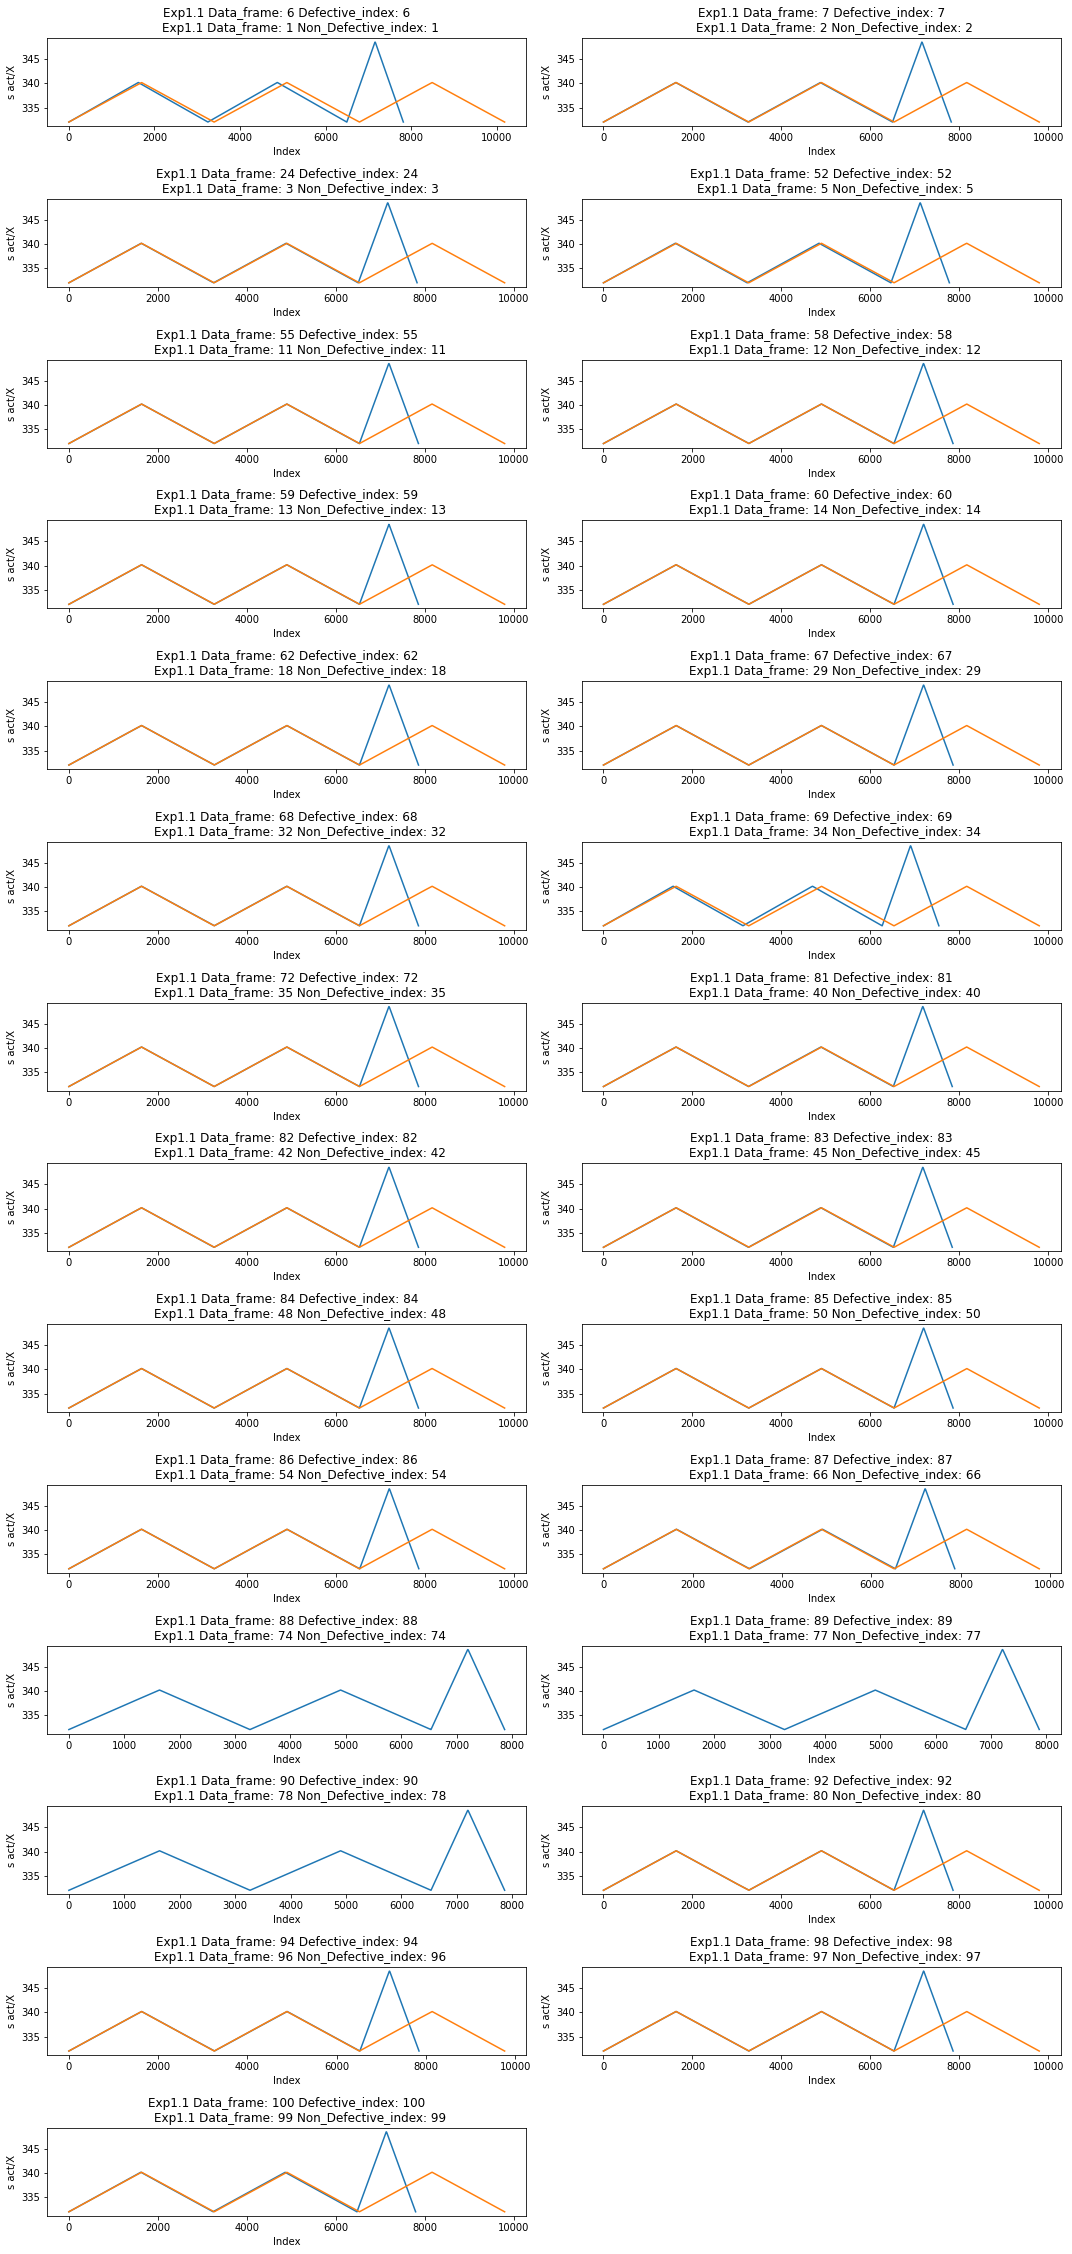

In [297]:
size = 101 ## size of dataframe
exp= exp_1 ## which part of experiment(exp_1, exp_2, exp_3)

#for a in range(1,7):
a=3
plt.figure(figsize=(15,60))
for i, k, j in zip(defected_index, range(len(non_defective)),non_defective) :
    plt.subplot(len(defected_index),2,k+1)
    if (i % 101 == 0) :
        plt.plot(exp[i//101][0].iloc[:,a])
        if (j % 101==0):
            plt.plot(exp[j//101][0].iloc[:,a])
            plt.title(f'''Exp1.{i//101+1} Data_frame: {0} Defective_index: {defected_index[k]}
            Exp1.{j//101+1} Data_frame: {0} Non_Defective_index: {non_defective[k]} ''')

        else:
            plt.plot(exp[j//101][j%101].iloc[:,a])
            plt.title(f'''Exp1.{i//101+1} Data_frame: {0} Defective_index: {defected_index[k]}
            Exp1.{j//101+1} Data_frame: {j%101} Non_Defective_index: {non_defective[k]} ''')

    else: 
        plt.plot(exp[i//101][i%101].iloc[:,a])
        plt.plot(exp[j//101][j%101].iloc[:,a])
        plt.title(f'''Exp1.{i//101+1} Data_frame: {i%101} Defective_index: {defected_index[k]}
        Exp1.{j//101+1} Data_frame: {j%101} Non_Defective_index: {non_defective[k]} ''' )
    plt.xlabel("Index")
    plt.ylabel(signal_data[a].columns[a])
    plt.tight_layout()